In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
include("module.jl")
using .PhasorNetworks

In [3]:
using Plots

In [4]:
using LinearAlgebra: triu, diagm, diag

In [5]:
using Statistics: std, median

In [6]:
using QuadGK

In [7]:
using Random: Xoshiro, AbstractRNG

# Construct a random graph

In [8]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1)

In [9]:
function generate_er_graph(n::Int, p::Real, rng::AbstractRNG, self_loops::Bool = false)
    adj = rand(rng, Float64, (n, n)) .< p
    #make undirected
    adj = triu(adj)
    adj =  (adj .+ adj') .> 0

    if !self_loops
        #remove self-loops
        for i in 1:n
            adj[i,i] = 0
        end
    end

    return adj
end

generate_er_graph (generic function with 2 methods)

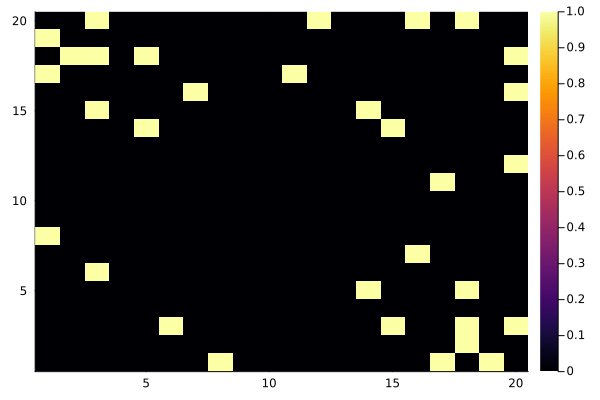

In [10]:
g1 = generate_er_graph(20, 0.1, rng)
heatmap(g1)

# Embed it into an HD vector

In [11]:
function define_node_symbols(graph::AbstractMatrix, nd::Int, rng::AbstractRNG)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)

    #create vectors representing the nodes
    node_values = random_symbols((n, nd), rng)
    return node_values
end

define_node_symbols (generic function with 1 method)

In [12]:
nv1 = define_node_symbols(g1, 1024, rng);

In [13]:
size(nv1)

(20, 1024)

In [14]:
function graph_to_vector(graph::AbstractMatrix, node_values::AbstractMatrix)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)
    nd = size(node_values, 2)

    #get cartesian coordinates representing each edge
    edges = findall(graph)
    n_edges = length(edges)
    edge_values = zeros(Float64, n_edges, nd)

    #iterate through the edges
    for (i, edge) in enumerate(edges)
        tx = edge[1]
        rx = edge[2]

        tx_symbol = node_values[tx,:]
        rx_symbol = node_values[rx,:]
        #create a representation for that edge by binding its incident nodes
        edge_symbol = PhasorNetworks.bind(tx_symbol, rx_symbol)
        edge_values[i,:] = edge_symbol
    end

    #combine the edges in the graph to the single embedding via bundling
    graph_embedding = bundle(edge_values, dims=1)
    return graph_embedding
end

graph_to_vector (generic function with 1 method)

In [15]:
gv1 = graph_to_vector(g1, nv1)

1×1024 Matrix{Float64}:
 0.84526  -0.685935  0.113604  -0.527913  …  -0.31853  -0.0367162  0.975287

In [16]:
sa = default_spk_args()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.02 (V)


In [17]:
function graph_to_vector(graph::AbstractMatrix, node_values::AbstractMatrix, spk_args::SpikingArgs; repeats::Int=5)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)
    nd = size(node_values, 2)
    
    #slice each node symbol into a spike train
    train_values = [phase_to_train(reshape(node, (1,:)), spk_args, repeats=repeats) for node in eachslice(node_values, dims=1)]
    tspan = (0.0, repeats * 1.0)
    
    #get cartesian coordinates representing each edge
    edges = findall(graph)
    n_edges = length(edges)
    edge_values = []

    #iterate through the edges
    function edge_to_train(edge)
        tx = edge[1]
        rx = edge[2]

        tx_symbol = train_values[tx]
        rx_symbol = train_values[rx]
        #create a representation for that edge by binding its incident nodes
        edge_symbol = PhasorNetworks.bind(tx_symbol, rx_symbol, spk_args=spk_args, tspan=tspan)
        return edge_symbol
    end

    edge_values = map(edge_to_train, edges)
    #combine the edges in the graph to the single embedding via bundling
    combined = vcat_trains(edge_values)
    graph_embedding = bundle(combined, dims=1, spk_args=spk_args, tspan=tspan)
    return train_values, graph_embedding, tspan
end

graph_to_vector (generic function with 2 methods)

In [18]:
nvt1, gvt1, tspan = graph_to_vector(g1, nv1, sa, repeats=5)

(SpikeTrain[Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes.], Spike Train: (1, 1024) with 5904 spikes., (0.0, 5.0))

In [19]:
phases = train_to_phase(gvt1, sa);

In [20]:
ss = similarity(gv1, zero_nans(phases[2,1:1,:]), dim=1)

1×1024 Matrix{Float64}:
 0.989908  0.98561  0.994433  0.958444  …  0.991525  0.980302  0.996988

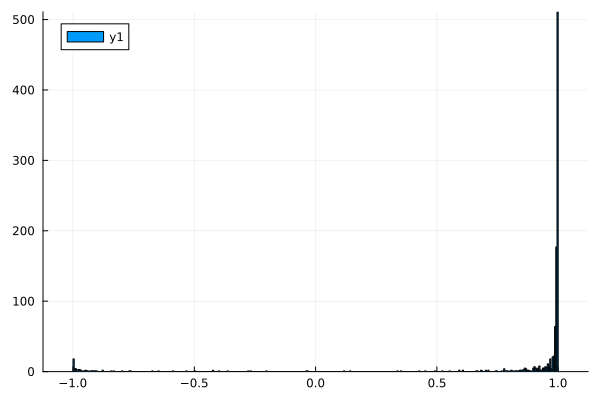

In [21]:
histogram(ss |> vec)

In [22]:
median(ss)

0.9949184947166423

# Use similarity to reconstruct the graph

In [23]:
function query_edges(graph::AbstractMatrix, nodes::AbstractMatrix)
    n = size(nodes, 1)
    nd = size(graph, 2)

    adj_rec = zeros(Float64, n, n)
    for (i,node) in enumerate(eachslice(nodes, dims=1))
        #add a dimension for consistency
        node = reshape(node, (1, :))
        query = unbind(graph, node)
        s = similarity_outer(query, nodes, dims=1) |> vec
        adj_rec[i,:] = s
    end

    return adj_rec
end

query_edges (generic function with 1 method)

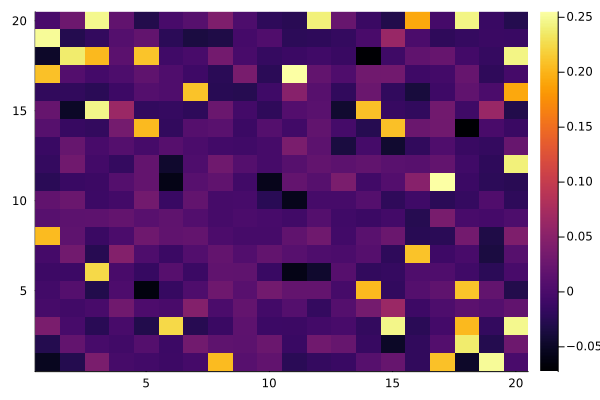

In [24]:
rec1 = query_edges(gv1, nv1)
heatmap(rec1)

In [25]:
function query_edges(graph::SpikeTrain, nodes::Vector{<:SpikeTrain}, spk_args::SpikingArgs, tspan::Tuple{<:Real, <:Real})
    all_nodes = vcat_trains(nodes)
    
    function query_edge(node)
        query = unbind(graph, node, tspan=tspan, spk_args=spk_args)
        s = similarity_outer(query, all_nodes, dims=1, reduce_dim=2, spk_args=sa, tspan=tspan)
        return s
    end
    
    similarity = map(query_edge, nodes)
    adj_rec = stack(map(x -> last.(x), similarity))[1,:,:]

    return adj_rec
end

query_edges (generic function with 2 methods)

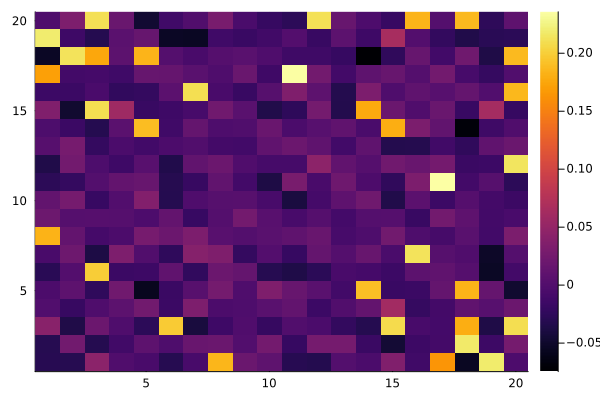

In [26]:
rec2 = query_edges(gvt1, nvt1, sa, tspan)
heatmap(rec2)

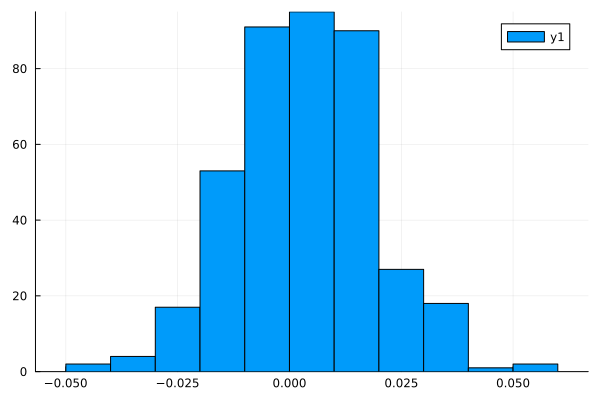

In [27]:
histogram((rec1 .- rec2)|> vec)

# Determine the quality of the reconstruction (AUROC)

In [28]:
function auroc(graph::AbstractMatrix, reconstruction::AbstractMatrix)
    tpr, fpr = tpr_fpr(vec(reconstruction), vec(graph))
    roc_fn = interpolate_roc((tpr, fpr))
    auc, err = quadgk(x -> roc_fn(x), 0.0, 1.0)
    return auc, err
end

auroc (generic function with 1 method)

In [29]:
auroc(g1, rec1)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010869565217391304, 0.010869565217391304, 0.010869565217391304, 0.016304347826086956, 0.02717391304347826, 0.03804347826086957, 0.043478260869565216, 0.07065217391304347, 0.09510869565217392, 0.11141304347826086, 0.12228260869565218, 0.13858695652173914, 0.1793478260869565, 0.21195652173913043, 0.23369565217391305, 0.25, 0.2554347826086957, 0.266304347826087, 0.2717391304347826, 0.28804347826086957, 0.3179347826086957, 0.328804347826087, 0.35597826086956524, 0.36684782608695654, 0.3695652173913043, 0.375, 0.375, 0.375, 0.375, 0.3858695652173913, 0.3967391304347826, 0.3967391304347826, 0.3967391304347826, 0.4076086956521739, 0.4076086956521739, 0.41304347826086957, 0.42391304347826086, 0.42391304347826086, 0.42391

(1.0, 0.0)

In [30]:
auroc(g1, rec2)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005434782608695652, 0.010869565217391304, 0.010869565217391304, 0.010869565217391304, 0.019021739130434784, 0.021739130434782608, 0.03260869565217391, 0.059782608695652176, 0.06521739130434782, 0.09510869565217392, 0.11956521739130435, 0.13043478260869565, 0.14945652173913043, 0.17391304347826086, 0.1983695652173913, 0.20923913043478262, 0.22826086956521738, 0.2418478260869565, 0.2554347826086957, 0.27717391304347827, 0.2907608695652174, 0.29891304347826086, 0.30978260869565216, 0.30978260869565216, 0.3179347826086957, 0.32608695652173914, 0.33967391304347827, 0.3451086956521739, 0.34782608695652173, 0.35597826086956524, 0.358695652173913, 0.36684782608695654, 0.37228260869565216, 0.375, 0.3804347826086957, 0.385

(1.0, 0.0)

In [31]:
auroc(g1, rand(rng, Float32, size(rec2)))

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = [0.0, 0.06793478260869565, 0.16032608695652173, 0.2391304347826087, 0.32608695652173914, 0.3858695652173913, 0.45108695652173914, 0.49728260869565216, 0.5461956521739131, 0.5815217391304348, 0.6141304347826086, 0.6494565217391305, 0.6766304347826086, 0.7038043478260869, 0.7336956521739131, 0.7635869565217391, 0.7961956521739131, 0.8125, 0.8288043478260869, 0.8505434782608695, 0.8614130434782609, 0.8804347826086957, 0.8913043478260869, 0.907608695652174, 0.9184782608695652, 0.9293478260869565, 0.9402173913043478, 0.9429347826086957, 0.9483695652173914, 0.9510869565217391, 0.9565217391304348, 0.9565217391304348, 0.9592391304347826, 0.9619565217391305, 0.967391304347826, 0.970108695652174, 0.9728260869565217, 0.9755434782608695, 0.9809782608695652, 0.9809782608695652, 0.9836956521739131, 0.9836956521739131, 0.9891304347826086, 0.9945652173913043, 0.9945652

(0.575959582829452, 7.920927685728819e-9)

In [32]:
tpr, fpr = tpr_fpr(vec(rec1), vec(g1))

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

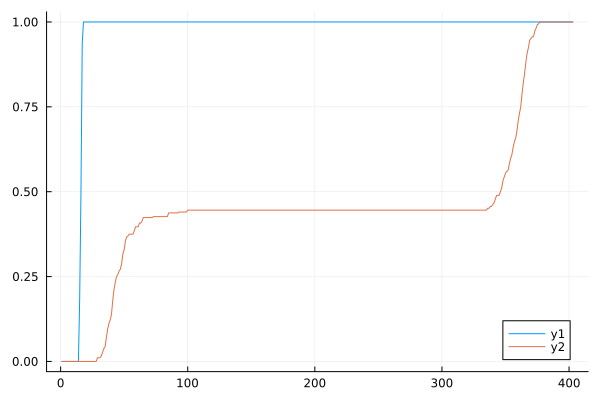

In [33]:
plot(tpr)
plot!(fpr)

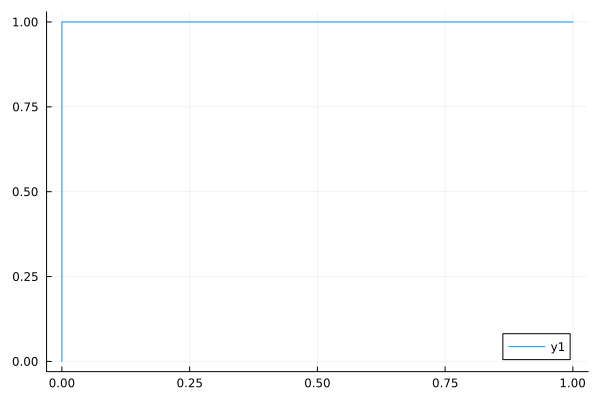

In [34]:
plot(fpr, tpr)

In [35]:
roc = interpolate_roc((tpr, fpr));

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010869565217391304, 0.010869565217391304, 0.010869565217391304, 0.016304347826086956, 0.02717391304347826, 0.03804347826086957, 0.043478260869565216, 0.07065217391304347, 0.09510869565217392, 0.11141304347826086, 0.12228260869565218, 0.13858695652173914, 0.1793478260869565, 0.21195652173913043, 0.23369565217391305, 0.25, 0.2554347826086957, 0.266304347826087, 0.2717391304347826, 0.28804347826086957, 0.3179347826086957, 0.328804347826087, 0.35597826086956524, 0.36684782608695654, 0.3695652173913043, 0.375, 0.375, 0.375, 0.375, 0.3858695652173913, 0.3967391304347826, 0.3967391304347826, 0.3967391304347826, 0.4076086956521739, 0.4076086956521739, 0.41304347826086957, 0.42391304347826086, 0.42391304347826086, 0.42391

In [36]:
quadgk(x -> roc(x), 0.0, 1.0)

(1.0, 0.0)

In [37]:
tpr2, fpr2 = tpr_fpr(vec(rec2), vec(g1))

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

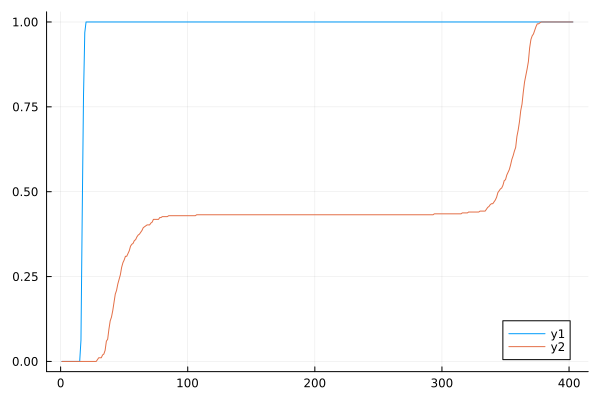

In [38]:
plot(tpr2)
plot!(fpr2)

In [39]:
quadgk(x -> interpolate_roc((tpr2, fpr2))(x), 0.0, 1.0)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005434782608695652, 0.010869565217391304, 0.010869565217391304, 0.010869565217391304, 0.019021739130434784, 0.021739130434782608, 0.03260869565217391, 0.059782608695652176, 0.06521739130434782, 0.09510869565217392, 0.11956521739130435, 0.13043478260869565, 0.14945652173913043, 0.17391304347826086, 0.1983695652173913, 0.20923913043478262, 0.22826086956521738, 0.2418478260869565, 0.2554347826086957, 0.27717391304347827, 0.2907608695652174, 0.29891304347826086, 0.30978260869565216, 0.30978260869565216, 0.3179347826086957, 0.32608695652173914, 0.33967391304347827, 0.3451086956521739, 0.34782608695652173, 0.35597826086956524, 0.358695652173913, 0.36684782608695654, 0.37228260869565216, 0.375, 0.3804347826086957, 0.385

(1.0, 0.0)

# Run an experiment over multiple graphs

In [40]:
function test_methods(n::Int, p::Real, d_vsa::Int, rng::AbstractRNG)
    graph = generate_er_graph(n, p, rng)
    node_symbols = define_node_symbols(graph, d_vsa, rng)

    #test with the floating-point method
    graph_static = graph_to_vector(graph, node_symbols)
    recon_static = query_edges(graph_static, node_symbols)
    auroc_static = auroc(graph, recon_static)

    #test with the oscillator-based method
    sa = default_spk_args()
    nodes_dynamic, graph_dynamic, tspan = graph_to_vector(graph, node_symbols, sa)
    recon_dynamic = query_edges(graph_dynamic, nodes_dynamic, sa, tspan)
    auroc_dynamic = auroc(graph, recon_dynamic)

    #return graph, recon_static, recon_dynamic
    return auroc_static, auroc_dynamic
end

test_methods (generic function with 1 method)

In [44]:
as, ad = test_methods(20, 0.5, 1024, rng)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007575757575757576, 0.015151515151515152, 0.022727272727272728, 0.03787878787878788, 0.05303030303030303, 0.07575757575757576, 0.08712121212121213, 0.10606060606060606, 0.10984848484848485, 0.125, 0.14772727272727273, 0.14772727272727273, 0.14772727272727273, 0.16287878787878787, 0.17045454545454544, 0.1856060606060606, 0.20833333333333334, 0.23863636363636365, 0.2689393939393939, 0.2765151515151515, 0.29924242424242425, 0.3181818181818182, 0.3409090909090909, 0.3409090909090909, 0.3409090909090909, 0.3409090909090909, 0.3484848484848485, 0.3484848484848485, 0.3484848484848485, 0.3484848484848485, 0.3522727272727273, 0.3522727272727273, 0.3522727272727273, 0.3522727272727273, 0.352272727272727

((1.0, 0.0), (0.9980921296450432, 1.093145226031475e-8))